# Dictionary Initialization

In [1]:
daily_log_likelihoods = {}
daily_regrets = {}

# Import Data

First date of training dataset:  2010-01-04 00:00:00
Last date of training dataset:  2019-02-08 00:00:00
len of training dataset:  2291

First date of validation dataset:  2019-02-11 00:00:00
Last date of validation dataset:  2021-09-14 00:00:00
len of validation dataset:  654

First date of test dataset:  2021-09-15 00:00:00
Last date of test dataset:  2024-05-21 00:00:00
len of test dataset:  675

total dataset lenght:  3620
sum of the three datasets:  3620
original returns dataframe dimension: (3620, 9)


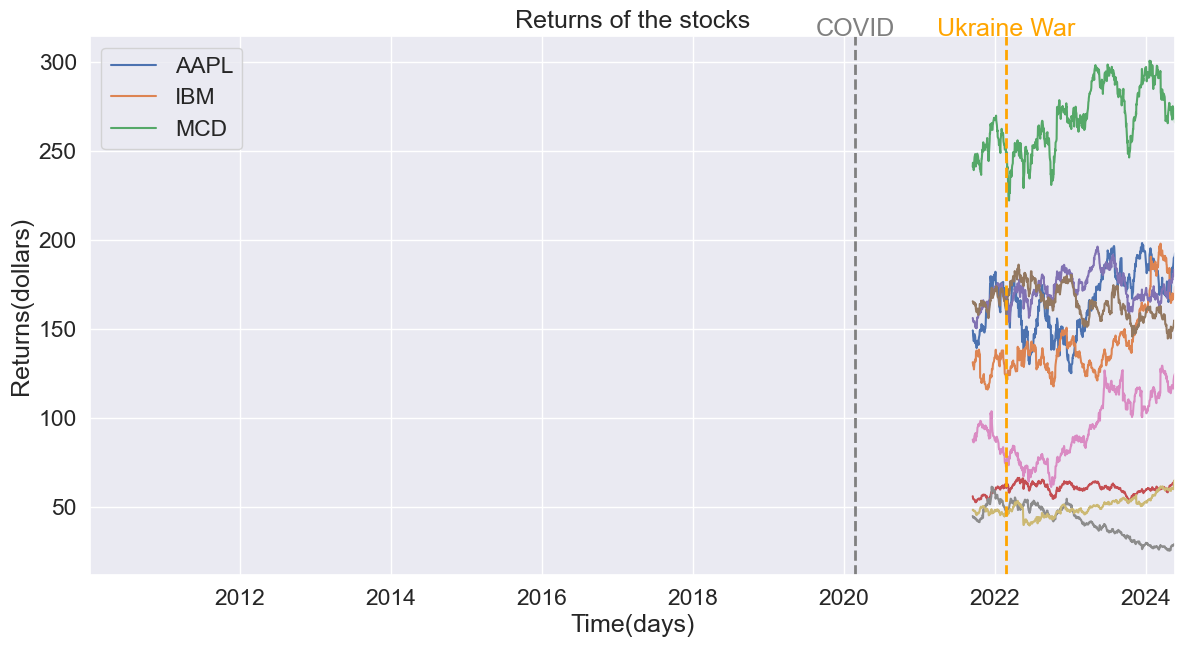

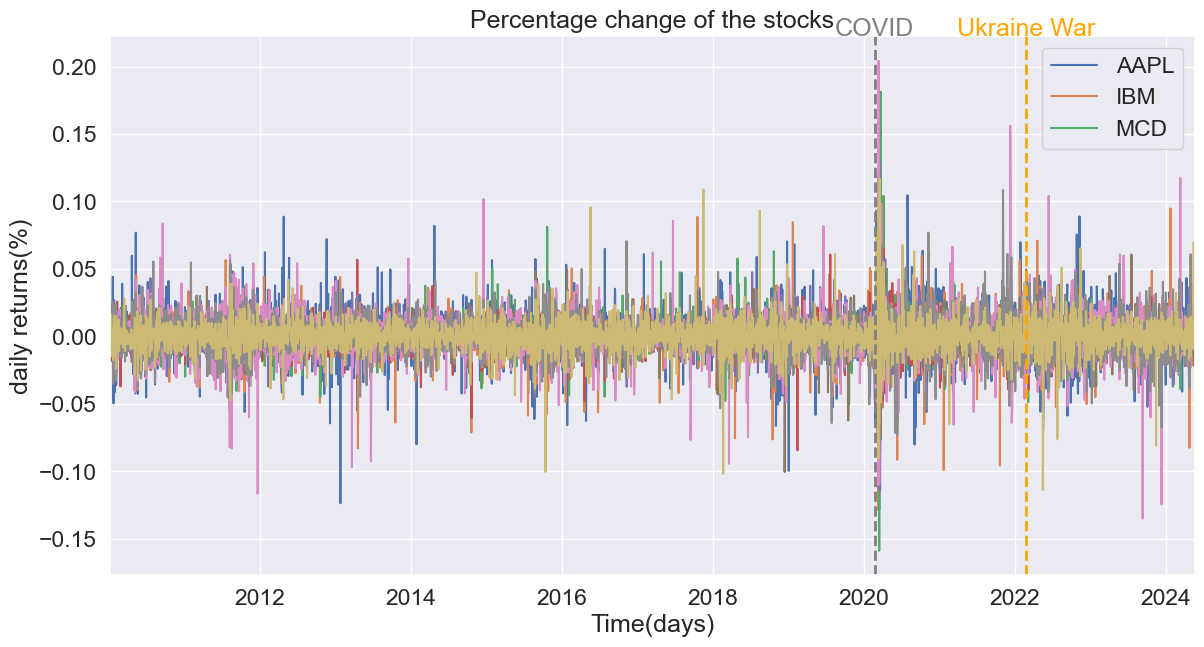

2010-01-04 00:00:00           7         20990     21177     20468     21384     21018     8045   \
7      0.000301  0.000114  0.000060  0.000044  0.000069  0.000056  0.000111   
20990  0.000114  0.000102  0.000041  0.000045  0.000053  0.000039  0.000084   
21177  0.000060  0.000041  0.000071  0.000036  0.000033  0.000015  0.000031   
20468  0.000044  0.000045  0.000036  0.000117  0.000050  0.000044  0.000049   
21384  0.000069  0.000053  0.000033  0.000050  0.000075  0.000030  0.000062   
21018  0.000056  0.000039  0.000015  0.000044  0.000030  0.000048  0.000045   
8045   0.000111  0.000084  0.000031  0.000049  0.000062  0.000045  0.000147   
21394  0.000101  0.000072  0.000029  0.000052  0.000051  0.000049  0.000088   
21880  0.000044  0.000026  0.000033  0.000036  0.000034  0.000016  0.000036   

          21394     21880  
7      0.000101  0.000044  
20990  0.000072  0.000026  
21177  0.000029  0.000033  
20468  0.000052  0.000036  
21384  0.000051  0.000034  
21018  0.000049  0.00

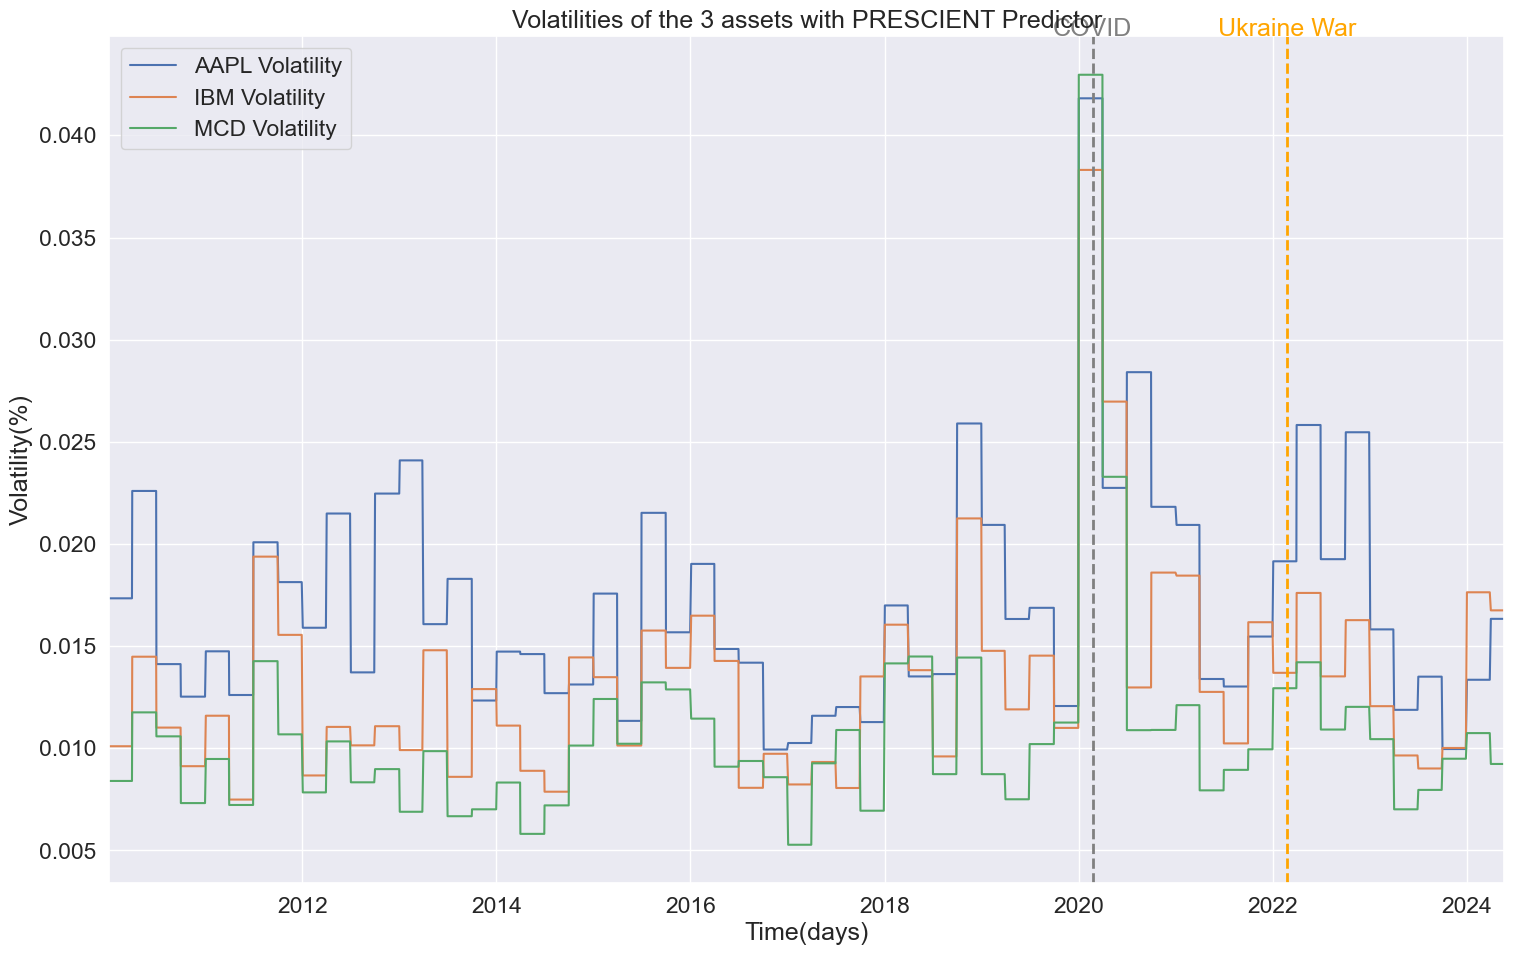

In [2]:
from predictorStarter import * # this file contains the import of every dataset, libraries needed and the initial plotting of the data
from predictorsImplementation import * # this file contains the implementation of the predictors ( one function implementation for each predictor)
from performanceMeasurement import * # this file contains the implementation of the performance measurement functions(like rmse, loglikelihood, regret, etc)

# Covariance Predictors

FOR THE MGARCH PREDICTOR I IMPORT THE COVARIANCE MATRICES ALREDY CALCULATED; SO IT'S LIKE THE TRAINING PART HAS BEEN DONE ALREADY, AND I NEED TO VERY THAT THE PREDICTOR IS WORKING PROPERLY(SO I NEED TO VERIFY THE VALIDATION PART)

# Validation Phase for MGARCH Predictor

with the armaOrder = (10,10) and the garchOrder = (10,10) and dccorder = (10,10) the performance are worse respect the case with armaOrder = (1,1) and garchOrder = (1,1) and dccorder = (1,1) -> at the moment the best performance are with the smallest order(this because the performance are more or less equal but the number of parameters are smaller in the case with the smallest order) -> with the smallest order the number of parameters are 17; the number of parameters with the order (10,10) are 149. so i prefer the smallest order

In [3]:
def modify_env_variable(env_file_path, variable_to_modify, new_value):
    '''
    code to modify the value of a specific variable in a .env file
    '''
    # Read the .env file
    with open(env_file_path, 'r') as file:
        lines = file.readlines()
    
    # Modify the specific variable
    modified_lines = []
    variable_found = False
    for line in lines:
        if line.startswith(variable_to_modify):
            modified_lines.append(f"{variable_to_modify}={new_value}\n")
            variable_found = True
        else:
            modified_lines.append(line)
    
    # If the variable was not found, add it to the file
    if not variable_found:
        modified_lines.append(f"{variable_to_modify}={new_value}\n")
    
    # Write the modified content back to the .env file
    with open(env_file_path, 'w') as file:
        file.writelines(modified_lines)

In [4]:
from mgarchAnalysis.flattenCovMatrices import *

def callRprocessAndUpdateCSVfile(csv_file_path, r_file_path):
    '''
    Function to call the R process and update the csv validation file
    '''
    # modify the environment variable USE_HYBRID_MGARCH to false
    modify_env_variable(file_path_first_part + 'experiments/.env', 'USE_HYBRID_MGARCH', 'False')

    csv_file_path = file_path_first_part + csv_file_path
    # Define the path to your R script
    r_script_path = file_path_first_part + r_file_path 

    # Define the command to run your R script
    command = ['Rscript', r_script_path]

    returnCode = 1

    while returnCode != 0:
        
        # Execute the command
        result = subprocess.run(command, capture_output=True, text=True)
        # if the code fails there is a problem of convergence so i keep trying to run the R script until it converges
        # Check if there was an error and raise an exception if so
        if result.returncode != 0:
            print("Error running the R script:")
            print(result.stderr)
        else:
            # If no error, print the output
            print("R script executed successfully:")
            print(result.stdout)
            returnCode = 0

    # Update the csv file with the validation results
    flattenAllMatrices(csv_file_path)

In [5]:
# MGARCH precomputed in R due to computational complexity
# now to automatize the process of obtaining the MGARCH predictions, i will call a function that will execute the r script that calculates the MGARCH predictions
# so the csv is updated with the MGARCH predictions and then i will read the csv file to obtain the MGARCH predictions
'''
callRprocessAndUpdateCSVfile("AllCovMatricesForValidation.csv", 'experiments/mgarchAnalysis/dccGarchTraningValidationTuning.r')

# The covariance matrices were computed for 100*r for numerical reasons 

mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedAllCovMatricesForValidation.csv", index_col=None)

# here we are obtaining the covariance matrix calculated for every day from the csv file;
# so this covariance matrix estimation is done with real returns and not with interpolated returns
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio

print("sigma shape:", Sigmas.shape)
# Remove the training dataset 
trainingSetLength = len(trainingDataWithPercentageChange)
testSetLength = len(testDataWithPercentageChange)
times = stocksPercentageChangeReturn.loc[validation_start_date:validation_end_date].index

print("len of times: ", len(times))

mgarchDict = {times[t]: pd.DataFrame(Sigmas[t], index=stocksPercentageChangeReturn.columns, columns=stocksPercentageChangeReturn.columns) for t in range(Sigmas.shape[0])}

print("mgarchDict len:", len(mgarchDict))
# print just the first key and value of the dictionary
print(list(mgarchDict.keys())[0]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[0]]) # TODO: delete this print
print("\n")
print(list(mgarchDict.keys())[-1]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[-1]]) # TODO: delete this print
'''

'\ncallRprocessAndUpdateCSVfile("AllCovMatricesForValidation.csv", \'experiments/mgarchAnalysis/dccGarchTraningValidationTuning.r\')\n\n# The covariance matrices were computed for 100*r for numerical reasons \n\nmgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedAllCovMatricesForValidation.csv", index_col=None)\n\n# here we are obtaining the covariance matrix calculated for every day from the csv file;\n# so this covariance matrix estimation is done with real returns and not with interpolated returns\nSigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio\n\nprint("sigma shape:", Sigmas.shape)\n# Remove the training dataset \ntrainingSetLength = len(trainingDataWithPercentageChange)\ntestSetLength = len(testDataWithPercentageChange)\ntimes = stocksPercentageChangeReturn.loc[validat

In [6]:
# now see how well the mgarch predictor is doing in predicting the real volatilities of the 3 assets by calculating the log-likelihood and the regret
start_date = pd.to_datetime(startingValidationDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingValidationDate, format="%Y-%m-%d")

In [7]:
'''
names = ["MGARCH", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [mgarchDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})
'''

'\nnames = ["MGARCH", "PRESCIENT"]\n\n#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  \npredictors_temp = [mgarchDict, prescientDict]\npredictors = [] # so this is a list of dictionaries\n\nfor predictor in predictors_temp:\n    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})\n'

In [8]:
# metrics to evaluate during the validation period: log-likelihood, regret, and MSE

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''
'''
log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]
    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    daily_log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)


# Iterate through each predictor in the log_likelihoods dictionary
for name in daily_log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        daily_log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        daily_log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot
'''

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''

'''
for name in daily_log_likelihoods:
    daily_regrets[name] =  daily_log_likelihoods["PRESCIENT"] - daily_log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        daily_regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.xlabel("Time(quarter)")
plt.ylabel("Regret")
plt.title("Regret")


for name in daily_regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        quarterly_regrets = daily_regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(quarterly_regrets).round(1), np.std(quarterly_regrets).round(1), np.max(quarterly_regrets).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
daily_log_likelihoods_copy = daily_log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in daily_log_likelihoods_copy:
    quarterly_logLikelihood = daily_log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(quarterly_logLikelihood).round(1), np.std(quarterly_logLikelihood).round(1), np.max(quarterly_logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")
'''

'\nfor name in daily_log_likelihoods:\n    daily_regrets[name] =  daily_log_likelihoods["PRESCIENT"] - daily_log_likelihoods[name]\n\n\nfig, ax = plt.subplots(1, 1, figsize=(10, 5))\nfor name in names:\n    if name == \'PRESCIENT\':\n        pass\n    else:\n        daily_regrets[name].resample("Q").mean().plot(label=name)\nplt.legend(bbox_to_anchor=(0.5, 1.1), loc=\'center\', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);\nplt.xlabel("Time(quarter)")\nplt.ylabel("Regret")\nplt.title("Regret")\n\n\nfor name in daily_regrets:\n    if name != "PRESCIENT":\n\n        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.\n        quarterly_regrets = daily_regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rathe

In [9]:
'''

# read from this file the covariance matrices calculated for the test phase
mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedAllCovMatricesForValidation.csv", index_col=None)

# here we are obtaining the covariance matrix calculated for every day from the csv file;
# so this covariance matrix estimation is done with real returns and not with interpolated returns
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio

print("sigma shape:", Sigmas.shape)
print(stocksPercentageChangeReturn.shape[1])
# Remove the training dataset 
trainingSetLength = len(trainingDataWithPercentageChange)
testSetLength = len(testDataWithPercentageChange)
times = stocksPercentageChangeReturn.loc[validation_start_date:validation_end_date].index

print("len of times: ", len(times))

mgarchDict = {times[t]: pd.DataFrame(Sigmas[t], index=stocksPercentageChangeReturn.columns, columns=stocksPercentageChangeReturn.columns) for t in range(Sigmas.shape[0])}

print("mgarchDict len:", len(mgarchDict))
# calculate the covariance matrix for the test phase

# print just the first key and value of the dictionary
print(list(mgarchDict.keys())[0]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[0]]) # TODO: delete this print
print("\n")
print(list(mgarchDict.keys())[-1]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[-1]]) # TODO: delete this print

# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingValidationDate)
real_volatility_endDate = pd.to_datetime(endingValidationDate)

df_volatility_aapl_mgarch, df_volatility_ibm_mgarch, df_volatility_mcd_mgarch, volatility_dict_aapl_mgarch, volatility_dict_ibm_mgarch, volatility_dict_mcd_mgarch = plot_volatility(mgarchDict, real_volatility_startDate, real_volatility_endDate, 'MGARCH')
'''

'\n\n# read from this file the covariance matrices calculated for the test phase\nmgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedAllCovMatricesForValidation.csv", index_col=None)\n\n# here we are obtaining the covariance matrix calculated for every day from the csv file;\n# so this covariance matrix estimation is done with real returns and not with interpolated returns\nSigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio\n\nprint("sigma shape:", Sigmas.shape)\nprint(stocksPercentageChangeReturn.shape[1])\n# Remove the training dataset \ntrainingSetLength = len(trainingDataWithPercentageChange)\ntestSetLength = len(testDataWithPercentageChange)\ntimes = stocksPercentageChangeReturn.loc[validation_start_date:validation_end_date].index\n\nprint("len of times: ", len(times))\n\n

In [10]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE MGARCH PREDICTOR COMPARED TO THE REAL VOLATILITY
'''
startDateFilter = validationDataWithPrices.index[0]
endDateFilter = validationDataWithPrices.index[-1]

plot_prices_volatilities_for_predictor(validationDataWithPrices, df_volatility_aapl["AAPL Volatility"], startDateFilter, endDateFilter, df_volatility_aapl_mgarch['AAPL Volatility'], 'AAPL', "MGARCH")
'''

'\nstartDateFilter = validationDataWithPrices.index[0]\nendDateFilter = validationDataWithPrices.index[-1]\n\nplot_prices_volatilities_for_predictor(validationDataWithPrices, df_volatility_aapl["AAPL Volatility"], startDateFilter, endDateFilter, df_volatility_aapl_mgarch[\'AAPL Volatility\'], \'AAPL\', "MGARCH")\n'

# Test Phase for MGARCH predictor

In this test phase i will use the best Mgarch model found in the validation phase to see the performance of the model on the test set and i will plot some charts to compare the volatility predicted by the model with the ground truth.

R script executed successfully:
[1] "TRAIN AND TEST RUN"

Model order: 3 
Training data size: 2291 
Validation data size: 654 
Testing data size: 675 
Length  Class   Mode 
     1 DCCfit     S4 

*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(3,3)
No. Parameters       :  114
[VAR GARCH DCC UncQ] : [0+72+6+36]
No. Series           :  9
No. Obs.             :  2290
Log-Likelihood       :  66896.42
Av.Log-Likelihood    :  29.21 

Optimal Parameters
-----------------------------------
               Estimate  Std. Error   t value Pr(>|t|)
[AAPL].mu      0.001326    0.000350  3.786500 0.000153
[AAPL].omega   0.000035    0.000020  1.754085 0.079416
[AAPL].alpha1  0.152199    0.051126  2.976930 0.002912
[AAPL].alpha2  0.031856    0.038685  0.823477 0.410237
[AAPL].alpha3  0.008727    0.085681  0.101858 0.918870
[AAPL].beta1   0.000079    0.222800  0.000353 0.999718
[AAPL].b

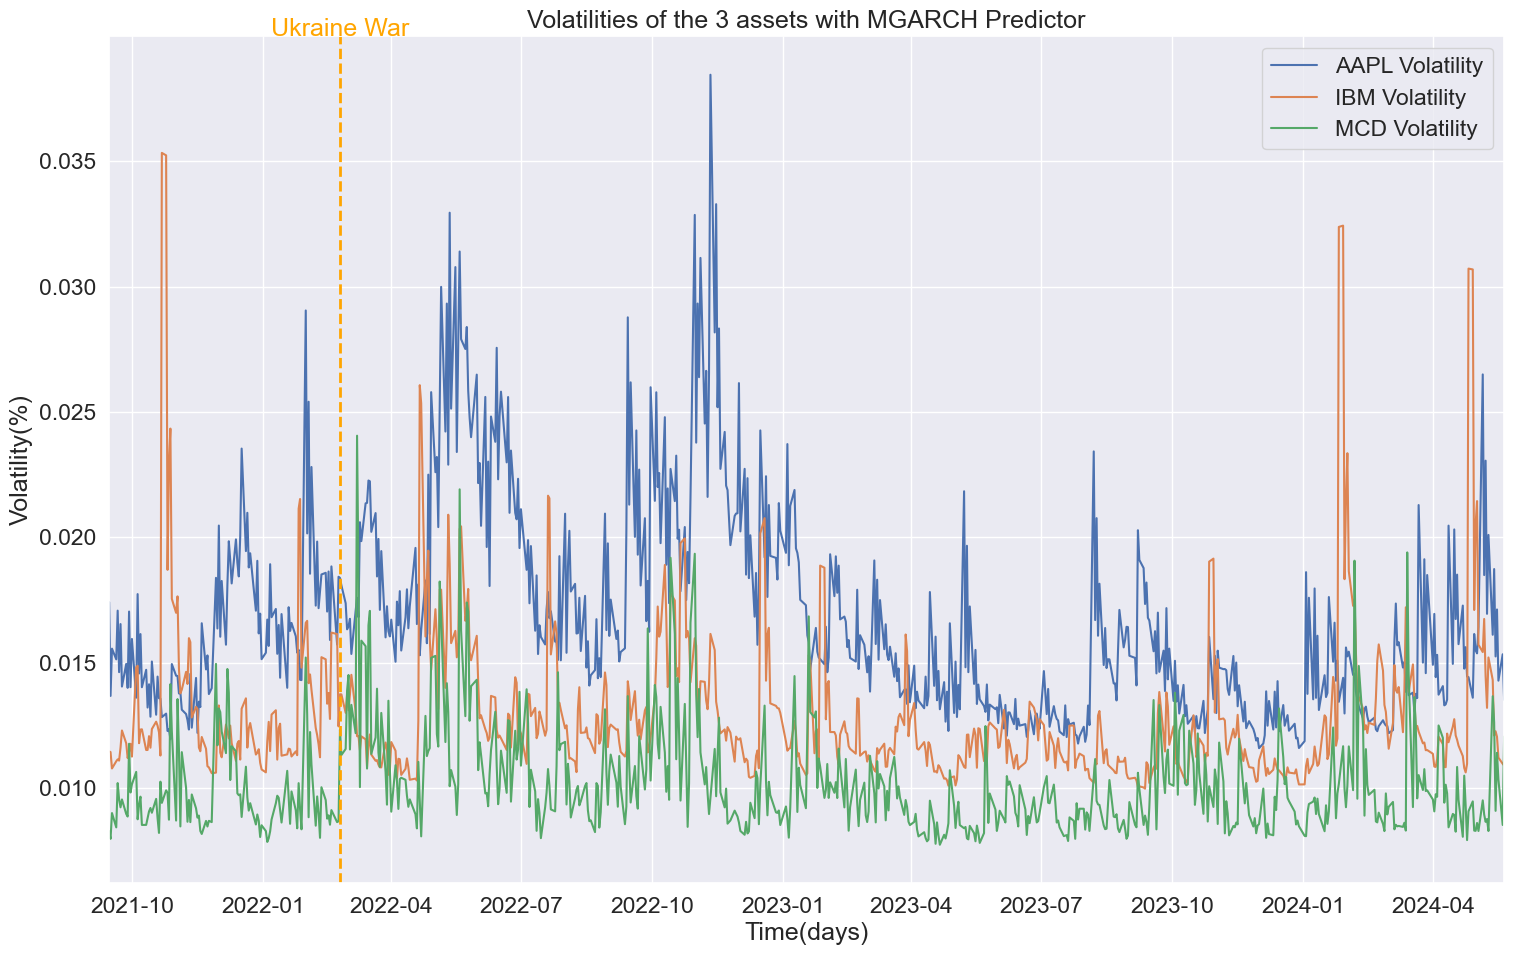

In [11]:
# MGARCH precomputed in R due to computational complexity
# now to automatize the process of obtaining the MGARCH predictions, i will call a function that will execute the r script that calculates the MGARCH predictions
# so the csv is updated with the MGARCH predictions and then i will read the csv file to obtain the MGARCH predictions

callRprocessAndUpdateCSVfile("AllCovMatricesForTesting.csv", "experiments/mgarchAnalysis/dccGarchTrainValidationTest.r")

# read from this file the covariance matrices calculated for the test phase
mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedAllCovMatricesForTesting.csv", index_col=None)

# here we are obtaining the covariance matrix calculated for every day from the csv file;
# so this covariance matrix estimation is done with real returns and not with interpolated returns
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio

print("sigma shape:", Sigmas.shape)
# Remove the training dataset 
trainingSetLength = len(trainingDataWithPercentageChange)
validationSetLength = len(validationDataWithPercentageChange)
times = stocksPercentageChangeReturn.index[trainingSetLength + validationSetLength:]

print("len of times: ", len(times))

mgarchDict = {times[t]: pd.DataFrame(Sigmas[t], index=stocksPercentageChangeReturn.columns, columns=stocksPercentageChangeReturn.columns) for t in range(Sigmas.shape[0])}

print("mgarchDict len:", len(mgarchDict))
# calculate the covariance matrix for the test phase

# print just the first key and value of the dictionary
print(list(mgarchDict.keys())[0]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[0]]) # TODO: delete this print
print("\n")
print(list(mgarchDict.keys())[-1]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[-1]]) # TODO: delete this print

# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

# assets names are AAPL, IBM, MCD, KO, PEP, JNJ, ORCL, PFE, WMT
df_volatility_aapl_mgarch, df_volatility_ibm_mgarch, df_volatility_mcd_mgarch, df_volatility_ko_mgarch, df_volatility_pep_mgarch, df_volatility_jnj_mgarch, df_volatility_orcl_mgarch, df_volatility_pfe_mgarch, df_volatility_wmt_mgarch, volatility_dict_aapl_mgarch, volatility_dict_ibm_mgarch, volatility_dict_mcd_mgarch, volatility_dict_ko_mgarch, volatility_dict_pep_mgarch, volatility_dict_jnj_mgarch, volatility_dict_orcl_mgarch, volatility_dict_pfe_mgarch, volatility_dict_wmt_mgarch = plot_volatility(mgarchDict, real_volatility_startDate, real_volatility_endDate, 'MGARCH')

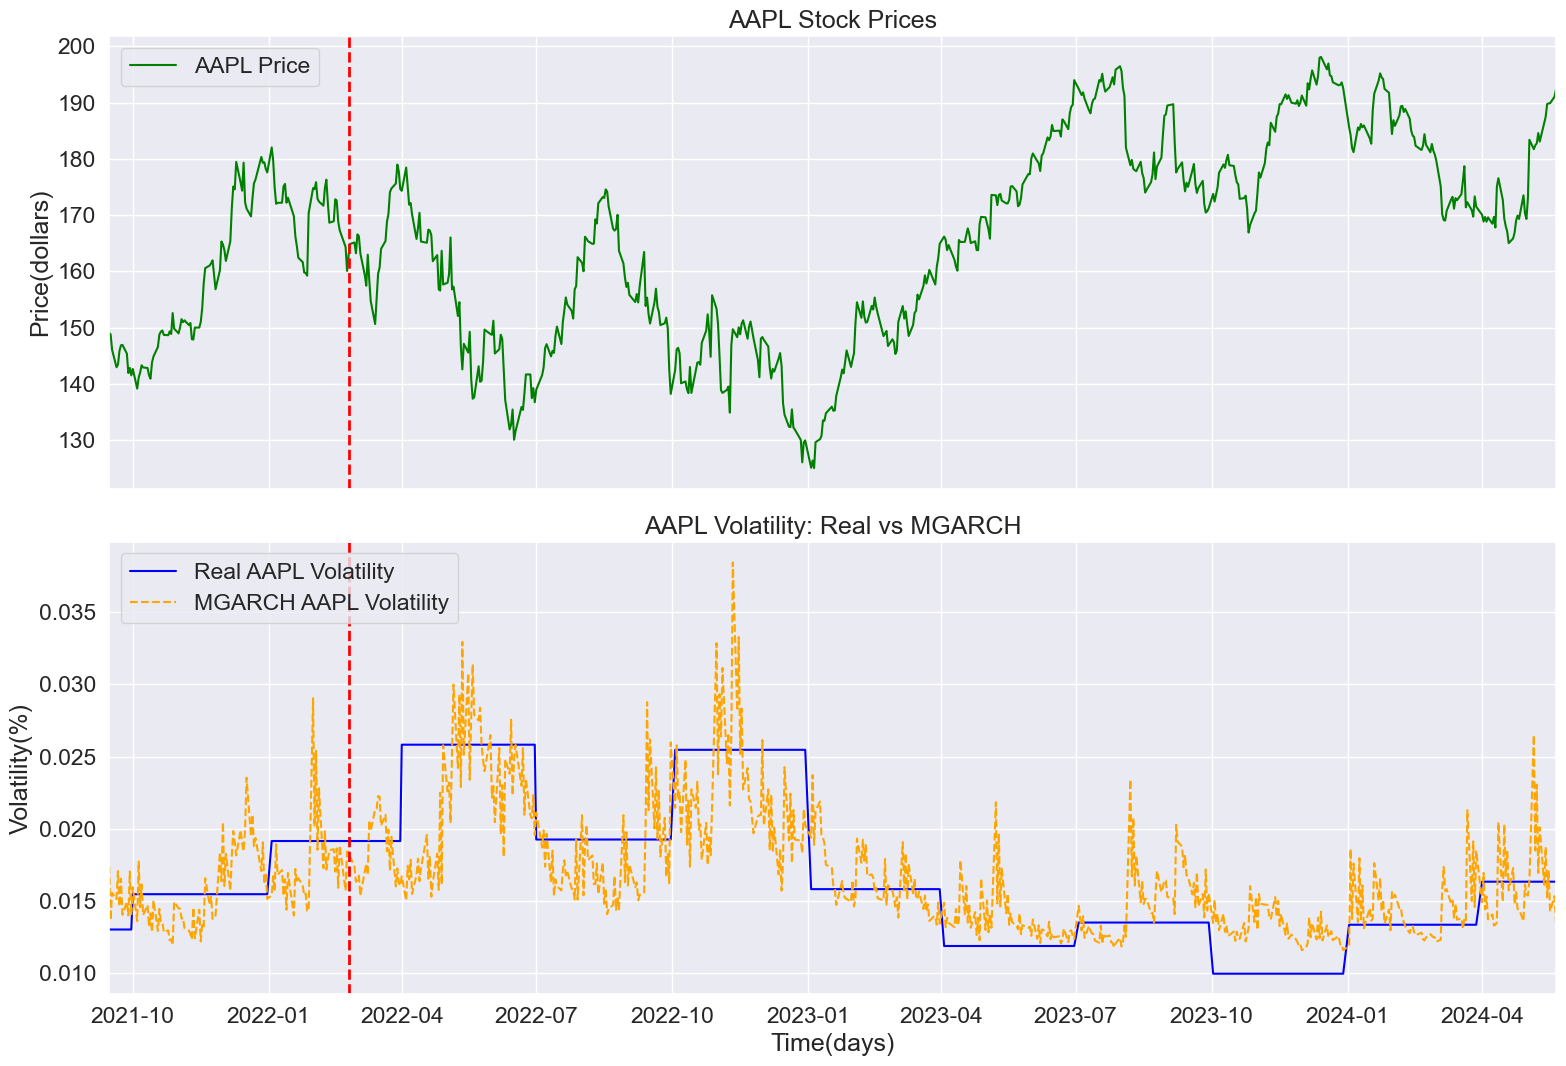

In [12]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE MGARCH PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_aapl["AAPL Volatility"], startDateFilter, endDateFilter, df_volatility_aapl_mgarch['AAPL Volatility'], 'AAPL', "MGARCH")

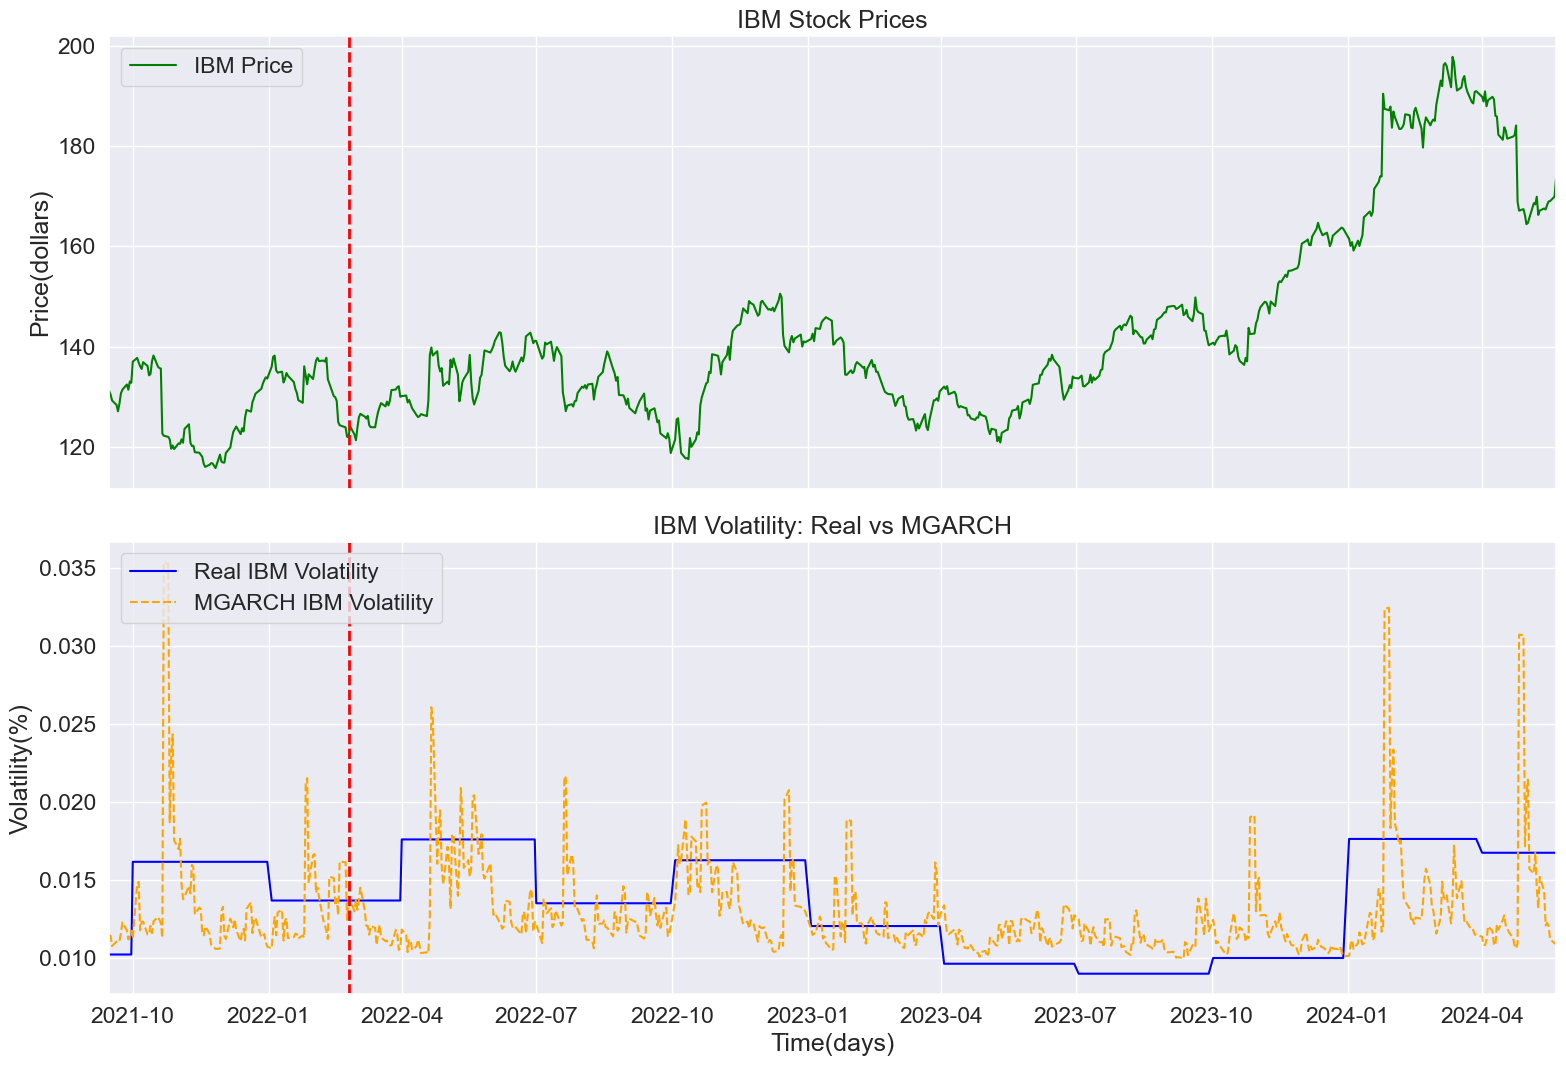

In [13]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE MGARCH PREDICTOR COMPARED TO THE REAL VOLATILITY
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_ibm["IBM Volatility"], startDateFilter, endDateFilter, df_volatility_ibm_mgarch['IBM Volatility'], 'IBM', "MGARCH")

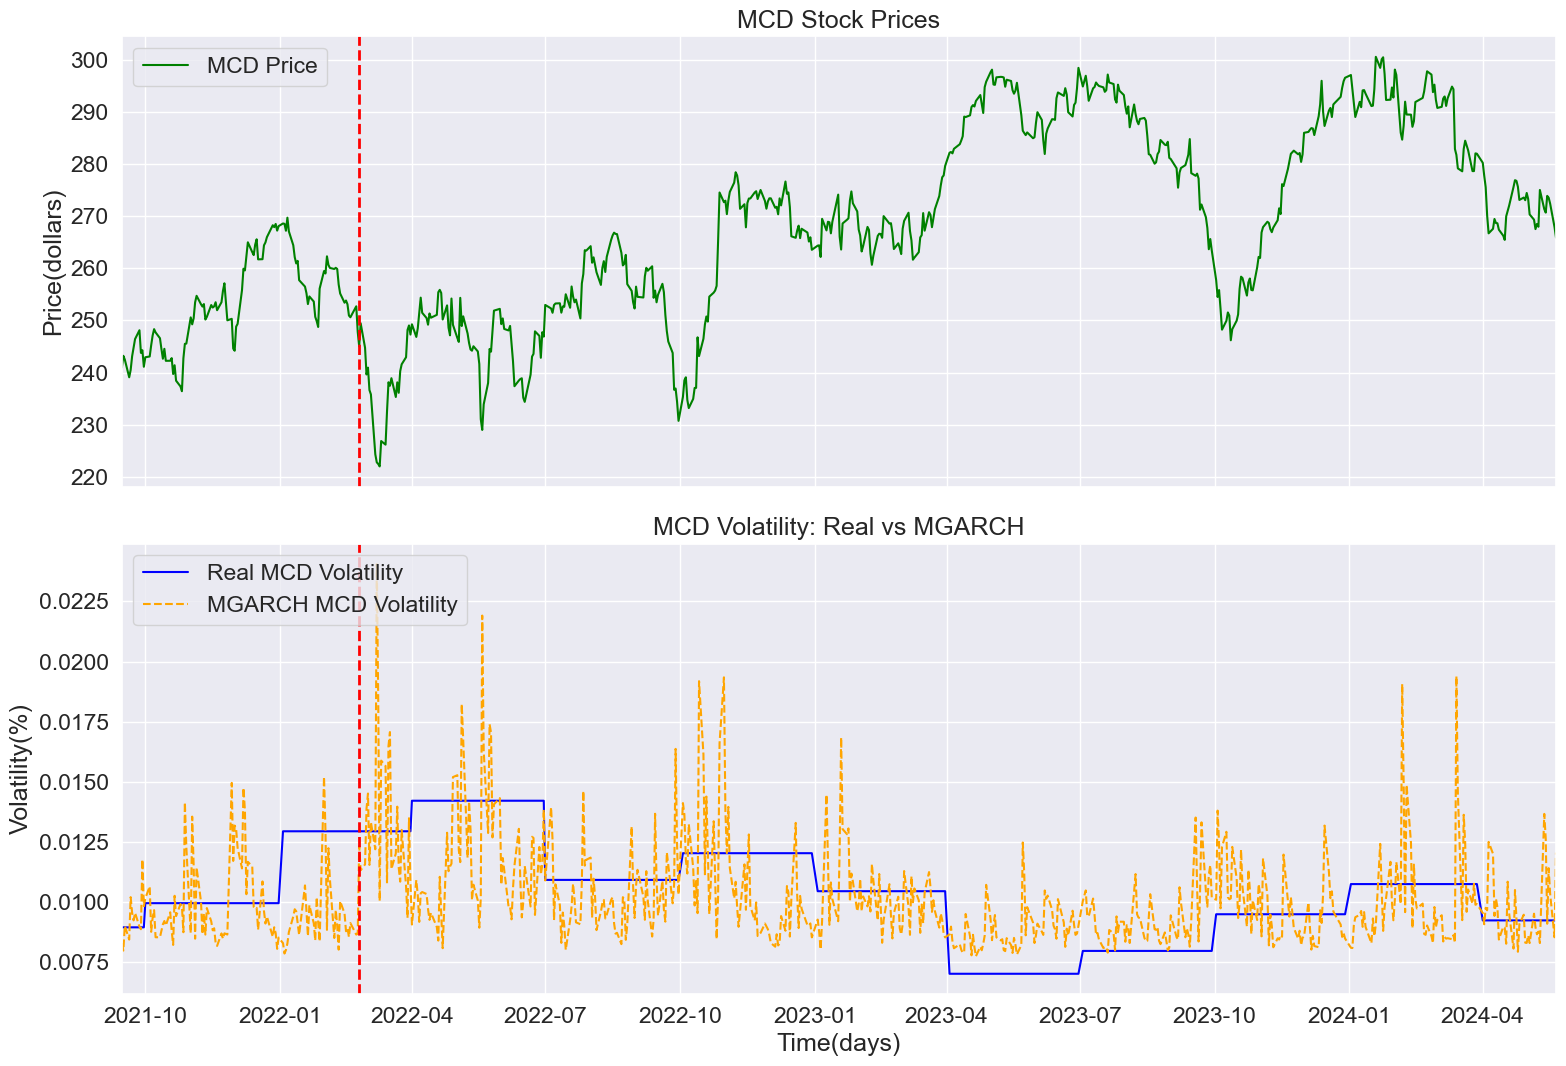

In [14]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE MGARCH PREDICTOR COMPARED TO THE REAL VOLATILITY
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_mcd["MCD Volatility"], startDateFilter, endDateFilter, df_volatility_mcd_mgarch['MCD Volatility'], 'MCD', "MGARCH")

size of the first predictor: 656
size of the second predictor: 656
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00


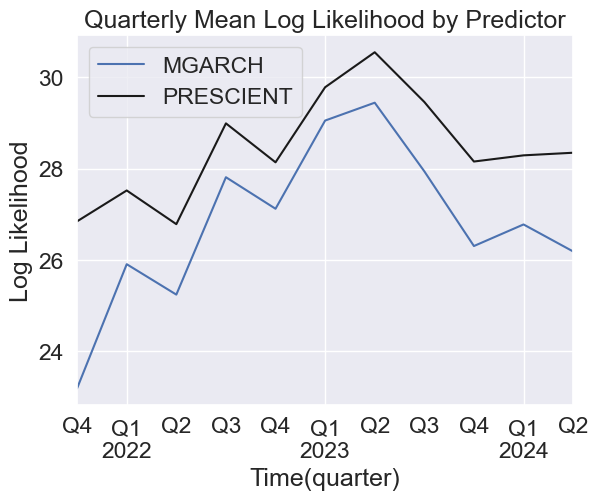

logLikelihood length:  11
logLikelihood shape:  (11,)


meanLoglikelihoodMGARCH: 26.800
stdLoglikelihoodMGARCH: 1.700
maxLoglikelihoodMGARCH: 29.400
logLikelihood length:  11
logLikelihood shape:  (11,)


meanLoglikelihoodPRESCIENT: 28.400
stdLoglikelihoodPRESCIENT: 1.100
maxLoglikelihoodPRESCIENT: 30.600


meanRegret: 1.600
stdRegret: 0.700
maxRegret: 3.700
lenght of prescientDict:  656
lenght of mgarchDict:  656
lenght of predictorDict:  656

MGARCH RMSE
mean: 0.0310283156
std: 0.0221527077
max: 0.0973518042
lenght of rmses:  11
values of rmses:  {Timestamp('2022-01-02 00:00:00'): 0.09735180417172705, Timestamp('2022-03-31 00:00:00'): 0.042394114221504464, Timestamp('2022-06-30 00:00:00'): 0.032724189821363985, Timestamp('2022-10-02 00:00:00'): 0.02051417224993473, Timestamp('2023-01-02 00:00:00'): 0.026161180711520085, Timestamp('2023-04-02 00:00:00'): 0.0155137392933401, Timestamp('2023-07-02 00:00:00'): 0.0179327436340587, Timestamp('2023-10-01 00:00:00'): 0.02319411143921142, Tim

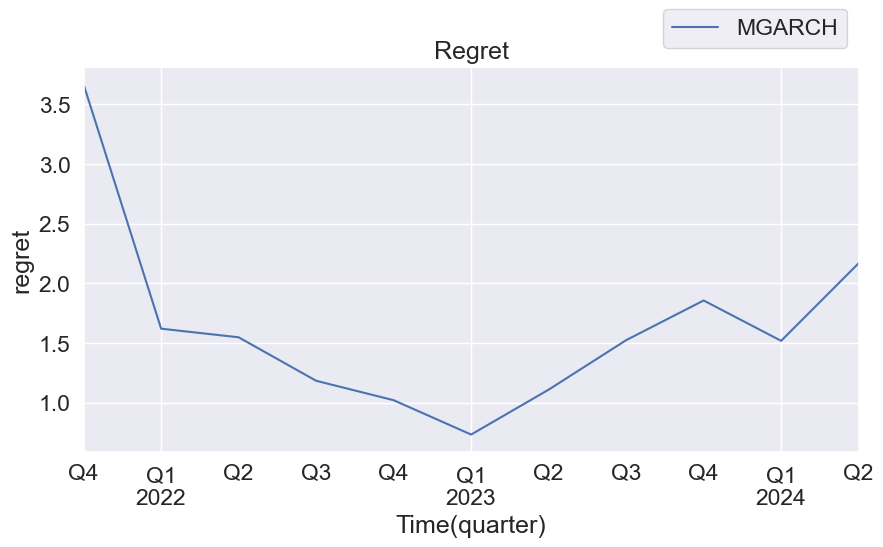

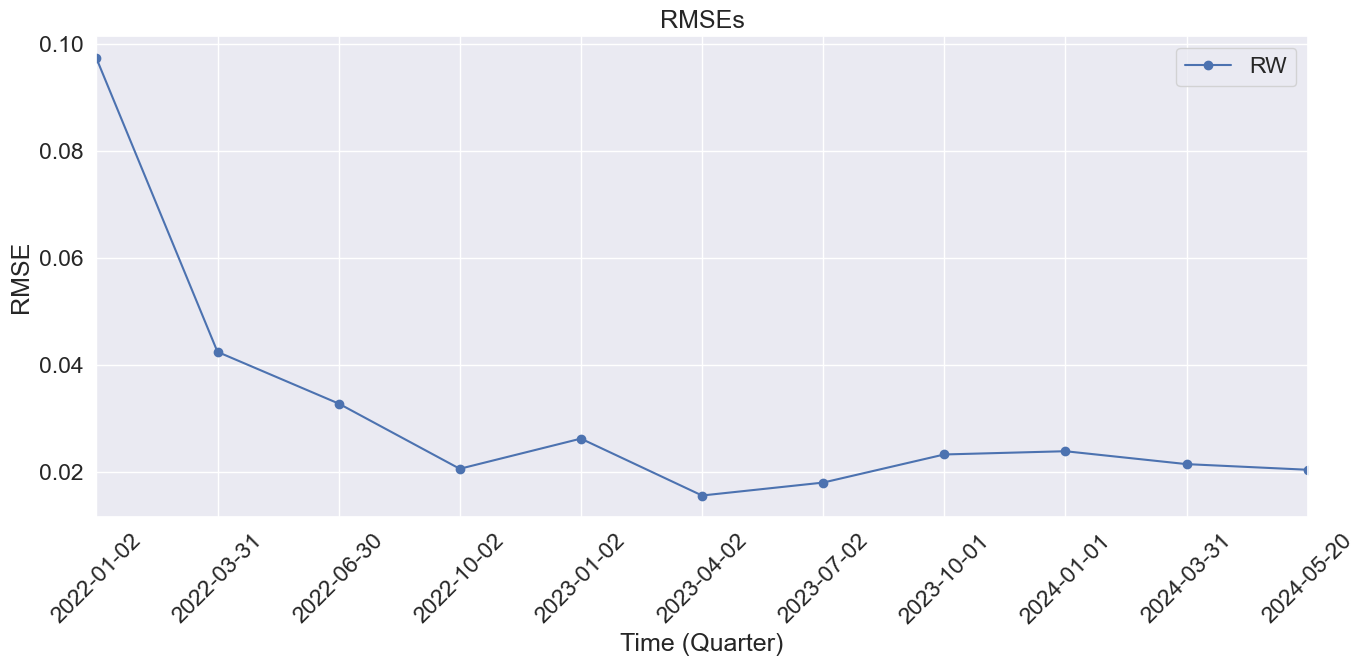

lenght of volatility_dict_aapl:  656
lenght of volatility_dict_aaapl_mgarch:  656
lenght of RMSEs_aapl:  11
values of RMSEs_aapl:  {Timestamp('2022-01-02 00:00:00'): 0.002668326035503812, Timestamp('2022-03-31 00:00:00'): 0.002937058943851792, Timestamp('2022-06-30 00:00:00'): 0.005710713808973798, Timestamp('2022-10-02 00:00:00'): 0.0033279002345082795, Timestamp('2023-01-02 00:00:00'): 0.005312149488426615, Timestamp('2023-04-02 00:00:00'): 0.0022204421735618598, Timestamp('2023-07-02 00:00:00'): 0.002591811751663335, Timestamp('2023-10-01 00:00:00'): 0.0028085338768319887, Timestamp('2024-01-01 00:00:00'): 0.003415739735143338, Timestamp('2024-03-31 00:00:00'): 0.0022501646101256876, Timestamp('2024-05-20 00:00:00'): 0.002817192187116968}


RMSEs for AAPL
mean: 0.0032781848
std: 0.0011137054
max: 0.0057107138


RMSEs for IBM
mean: 0.0033637397
std: 0.0014516470
max: 0.0055744846


RMSEs for MCD
mean: 0.0021716149
std: 0.0007631225
max: 0.0035983569
Stored 'mgarchDictFiltered' (dict)

In [15]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE MGARCH PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["MGARCH", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [mgarchDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

mgarchDict = predictors[0]
mgarchDict = {k: mgarchDict[k] for k in list(mgarchDict)[19:]}
predictors[0] = mgarchDict

# now remove the first 19 entries from the predictor 1(prescient dict)
prescientDict = predictors[1]

# now remove the first 19 entries from the prescient dict
prescientDict = {k: prescientDict[k] for k in list(prescientDict)[19:]}
predictors[1] = prescientDict

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))

# if we are here, it means that the two predictors have the same length and the same timestamps so i can measure the performance of the two predictors

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

daily_log_likelihoods = predictorLogLikelihood(stocksPercentageChangeReturn, predictors, names)

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
predictorRegret(daily_log_likelihoods, names)

#
# RMSEs
#

print("lenght of prescientDict: ", len(prescientDict))
print("lenght of mgarchDict: ", len(mgarchDict))
        
RMSEcovarianceMatrix(testDataWithPercentageChange, predictors, prescientDict, start_date, names)

#
# RMSEs for single assets
#
        
# take the first timestamp contained in prescientDict and use it as the start date
startDAte = list(prescientDict.keys())[0]

# filter every volatility dictionary to get only the values that are greater than or equal to the start date
volatility_dict_aapl_filtered = {k: v for k, v in volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_filtered = {k: v for k, v in volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_filtered = {k: v for k, v in volatility_dict_mcd.items() if k >= startDAte}
volatility_dict_ko_filtered = {k: v for k, v in volatility_dict_ko.items() if k >= startDAte}
volatility_dict_pep_filtered = {k: v for k, v in volatility_dict_pep.items() if k >= startDAte}
volatility_dict_jnj_filtered = {k: v for k, v in volatility_dict_jnj.items() if k >= startDAte}
volatility_dict_orcl_filtered = {k: v for k, v in volatility_dict_orcl.items() if k >= startDAte}
volatility_dict_pfe_filtered = {k: v for k, v in volatility_dict_pfe.items() if k >= startDAte}
volatility_dict_wmt_filtered = {k: v for k, v in volatility_dict_wmt.items() if k >= startDAte}

volatility_dict_aapl_mgarch_filtered = {k: v for k, v in volatility_dict_aapl_mgarch.items() if k >= startDAte}
volatility_dict_ibm_mgarch_filtered = {k: v for k, v in volatility_dict_ibm_mgarch.items() if k >= startDAte}
volatility_dict_mcd_mgarch_filtered = {k: v for k, v in volatility_dict_mcd_mgarch.items() if k >= startDAte}
volatility_dict_ko_mgarch_filtered = {k: v for k, v in volatility_dict_ko_mgarch.items() if k >= startDAte}
volatility_dict_pep_mgarch_filtered = {k: v for k, v in volatility_dict_pep_mgarch.items() if k >= startDAte}
volatility_dict_jnj_mgarch_filtered = {k: v for k, v in volatility_dict_jnj_mgarch.items() if k >= startDAte}
volatility_dict_orcl_mgarch_filtered = {k: v for k, v in volatility_dict_orcl_mgarch.items() if k >= startDAte}
volatility_dict_pfe_mgarch_filtered = {k: v for k, v in volatility_dict_pfe_mgarch.items() if k >= startDAte}
volatility_dict_wmt_mgarch_filtered = {k: v for k, v in volatility_dict_wmt_mgarch.items() if k >= startDAte}


print("lenght of volatility_dict_aapl: ", len(volatility_dict_aapl_filtered))
print("lenght of volatility_dict_aaapl_mgarch: ", len(volatility_dict_aapl_mgarch_filtered))

# get the rmse of single assets. i take just aapl, ibm and mcd
RMSEforSingleAssets(testDataWithPercentageChange, volatility_dict_aapl_filtered, volatility_dict_ibm_filtered, volatility_dict_mcd_filtered, volatility_dict_aapl_mgarch_filtered, volatility_dict_ibm_mgarch_filtered, volatility_dict_mcd_mgarch_filtered, start_date)

mgarchDictFiltered = predictors[0]
prescientDictFiltered = predictors[1]

# store the covariance matrixes dict of the filtered dataset
%store mgarchDictFiltered
%store prescientDictFiltered

Now here i store all the variables that i need to pass to other notebooks.

In [16]:
# create a dictionary for the volatilities of the rw predictor
mgarch_volatilities = {}

# add the volatilities of the 3 assets to the dictionary
mgarch_volatilities["AAPL"] = volatility_dict_aapl_mgarch_filtered
mgarch_volatilities["IBM"] = volatility_dict_ibm_mgarch_filtered
mgarch_volatilities["MCD"] = volatility_dict_mcd_mgarch_filtered

if numberOfAssets == 6:
    # add the volatilities of the 3 assets to the dictionary
    mgarch_volatilities["KO"] = volatility_dict_ko_mgarch_filtered
    mgarch_volatilities["PEP"] = volatility_dict_pep_mgarch_filtered
    mgarch_volatilities["JNJ"] = volatility_dict_jnj_mgarch_filtered

if numberOfAssets == 9:
    # add the volatilities of the 3 assets to the dictionary
    mgarch_volatilities["KO"] = volatility_dict_ko_mgarch_filtered
    mgarch_volatilities["PEP"] = volatility_dict_pep_mgarch_filtered
    mgarch_volatilities["JNJ"] = volatility_dict_jnj_mgarch_filtered
    mgarch_volatilities["ORCL"] = volatility_dict_orcl_mgarch_filtered
    mgarch_volatilities["PFE"] = volatility_dict_pfe_mgarch_filtered
    mgarch_volatilities["WMT"] = volatility_dict_wmt_mgarch_filtered

# store the dictionary
%store mgarch_volatilities

Stored 'mgarch_volatilities' (dict)
